# TensorFlow Lite model optimization

TensorFlow Lite에서는 edge device에서 모델의 inference를 효율적으로 하기 위한 방법인 quantization과 pruning을 이용할 수 있는 toolkit을 제공하고 있습니다. 이번 실습에서는 해당 toolkit을 이용해 볼 것입니다.

더 자세한 내용은 document를 참고 해주세요.
- https://www.tensorflow.org/model_optimization/guide
- https://www.tensorflow.org/lite/performance/model_optimization
- TFLite https://www.tensorflow.org/lite/guide

## 0. What is TFLite?

TensorFlow Lite는 TensorFlow로 학습된 모델을 tflite이라는 포맷으로 바꿔 줌으로써 모바일 장치, 임베디드 장치 등의 가벼운 장치에서 모델을 inference 할 수 있게 해주는 플랫폼 이다.

<img src="https://user-images.githubusercontent.com/37704174/115159215-fccd0800-a0cc-11eb-817b-645f96c76966.png" width="400" height="400"/>  


TensorFlow는 모델을 파일로 저장할 때는 [Protocol Buffer](https://developers.google.com/protocol-buffers)라는 포맷으로 저장을 하고, TensorFlow Lite의 모델은 [FlatBuffer](https://google.github.io/flatbuffers/)라는 포맷으로 저장을 합니다. 두 포맷의 가장 큰 차이점은 FlatBuffer는 serialized 파일을 추가적인 메모리 할당 없이 deserialize를 할 수 있기 때문에 빠르게 파일에 있는 데이터에 접근할 수 있다.


TFLite 모델로 변환을 할 때, quantization과 pruning 등의 optimization을 할 수 있는데, 이 때의 장점은 다음과 같다.

- Size reduction
  - smaller storage size, smaler download size, less memory usage
- Latency reduction
  - computation을 줄여 줌으로써 inference에 걸리는 시간 감소
- Accelerator compatibility
  - Edge TPU와 같이 특정 hardware는 각각의 quantization 요구 사항을 만족해야 함

tensorflow 최신 버전 설치

In [1]:
!pip install -q --upgrade tensorflow

In [1]:
import os
import numpy as np
import zipfile
import tempfile
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.6

tf.random.set_seed(1111)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
tf.__version__

'2.9.1'

## 1. Quantization
### 1-1. [Post-training quantization](https://blog.tensorflow.org/2019/06/tensorflow-integer-quantization.html)

post-training quantization은 학습을 한 다음에 quantization을 하는 방법이다. quantization aware training보다는 accuracy가 좀 떨어질 수 있지만, 학습된 모델을 가져와서 쉽게 쓸 수 있다. tensorflow에서 다음과 같은 방법들을 제공하고 있다.


<img src="https://user-images.githubusercontent.com/37704174/114367164-2232b100-9bb7-11eb-81e7-b9b8dec09de5.png" width="700" height="700"/>  
- dynamic range quantization: weight은 8 bit integer로 저장. inference 시에는 8bit float로 바뀜. activation은 range에 따라서(dynamic) 8 bit float으로 저장


나중에 Edge TPU가 있는 Coral board를 사용할 것이기 때문에, post-training integer quantization을 다뤄 볼 것이다.


먼저 quantizaion을 할 간단한 모델을 학습한다.

In [3]:
# Load MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the input image
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28)),
    tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile and Train
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=False),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,  
  epochs=10,
  validation_split=0.1
)

metrics = model.evaluate(test_images, test_labels)

Epoch 1/10
1688/1688 [==============================] - 21s 4ms/step - loss: 0.4777 - accuracy: 0.8306 - val_loss: 0.3759 - val_accuracy: 0.8670
Epoch 2/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3323 - accuracy: 0.8826 - val_loss: 0.3356 - val_accuracy: 0.8808
Epoch 3/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2934 - accuracy: 0.8958 - val_loss: 0.2888 - val_accuracy: 0.8948
Epoch 4/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2668 - accuracy: 0.9050 - val_loss: 0.2773 - val_accuracy: 0.9003
Epoch 5/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2471 - accuracy: 0.9106 - val_loss: 0.2603 - val_accuracy: 0.9047
Epoch 6/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2308 - accuracy: 0.9161 - val_loss: 0.2913 - val_accuracy: 0.8927
Epoch 7/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2186 - accuracy: 0.9216 - val_loss: 0.2598 - val_accuracy

In [4]:
print(f"Model test loss: {metrics[0]:.03f} | test accuracy: {metrics[1]*100:.02f}%")

Model test loss: 0.273 | test accuracy: 90.67%


학습된 모델을 변환하기 위해서는 [TensorFlow Lite converter](https://www.tensorflow.org/lite/convert)라는 것을 이용해야 합니다. 이것은 TensorFlow 모델을 TensorFlow Lite 모델로 바꿔 줍니다.

다음과 같이 tflite 모델로 변환할 수 있습니다.

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\steve\AppData\Local\Temp\tmp6ob4_9iy\assets


INFO:tensorflow:Assets written to: C:\Users\steve\AppData\Local\Temp\tmp6ob4_9iy\assets


변환할 때 아무런 옵션을 주지 않았으므로 이 모델은 단순히 32-bit float tflite 모델입니다.

### Post-training integer quantization


<img src="https://user-images.githubusercontent.com/37704174/114906428-f9c7e280-9e54-11eb-9038-9854d5c8d741.png" width="700" height="700"/>  
<img src="https://user-images.githubusercontent.com/37704174/114907026-9e4a2480-9e55-11eb-980f-55999688c260.png" width="500" height="500"/>  


다음 셀을 실행하면 quantization이 완료 된다.

In [6]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8 # or tf.int8
converter.inference_output_type = tf.uint8 # or tf.int8

post_quant_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\steve\AppData\Local\Temp\tmpbul3oa68\assets


INFO:tensorflow:Assets written to: C:\Users\steve\AppData\Local\Temp\tmpbul3oa68\assets
C:\Users\steve\.conda\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


evaluate을 위한 helper function이다. input type을 integer로 했으므로, quantize를 한 다음에 inference를 한다.

In [7]:
from tqdm import tqdm

def evaluate_model(interpreter):
    global test_images
    
    input_details = interpreter.get_input_details()[0]
    input_index = input_details["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for test_image in tqdm(test_images):
        # quantize input
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        # Pre-processing: add batch dimension
        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        
    print()
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy, output

tflite 모델로 inference를 하려면 [`Interpreter`](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter)를 이용한다. `model_content` 대신에 `model_path`를 이용하면 tflite 파일을 불러올 수도 있다.  
inference를 하기 위해서는  
interpreter 생성 &#8594; `allocate_tensor` &#8594; `set_tensor` &#8594; `invoke` 순으로 실행한다.  
지금 코드는 inference 할 때 image를 하나씩 처리하는데, batch 단위로 처리하려면 `resize_tensor_input`을 이용한다.

In [8]:
# 32bit float tflite 모델로 interpreter 만듦
interpreter = tf.lite.Interpreter(model_content=tflite_model)

# inference 할 때 input batch 수를 설정하하는 법
# input_details = interpreter.get_input_details()[0]
# interpreter.resize_tensor_input(input_details["index"], [10, 28, 28]) # <-- 추가

interpreter.allocate_tensors()
tflite_test_accuracy, _ = evaluate_model(interpreter)

# 8bit integer tflite
post_quant_interpreter = tf.lite.Interpreter(model_content=post_quant_tflite_model)
post_quant_interpreter.allocate_tensors()
post_quant_tflite_test_accuracy, output = evaluate_model(post_quant_interpreter)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2549.73it/s]


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:21<00:00, 122.80it/s]

`get_input_details`, `get_output_details`를 통해 input과 output의 type 및 quantization 정보를 알 수 있다.

In [9]:
post_quant_interpreter.get_input_details()

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([ 1, 28, 28]),
  'shape_signature': array([-1, 28, 28]),
  'dtype': numpy.uint8,
  'quantization': (0.003921568859368563, 0),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([0]),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [10]:
post_quant_interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 24,
  'shape': array([ 1, 10]),
  'shape_signature': array([-1, 10]),
  'dtype': numpy.uint8,
  'quantization': (0.00390625, 0),
  'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
   'zero_points': array([0]),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

실제로 inference output이 정수임을 확인할 수 있다.

In [11]:
print(output())

[[  1   0   1   0   0 222   0  25   6   1]]


float 32 모델과 accuracy를 비교해 보자.

In [12]:
print('TFLite test accuracy:', tflite_test_accuracy)
print('Post-training Quant TFLite test_accuracy:', post_quant_tflite_test_accuracy)

TFLite test accuracy: 0.9067
Post-training Quant TFLite test_accuracy: 0.9072


모델을 파일로 저장해서 실제로 모델 크기가 줄어들었는지 확인해 보자.

In [13]:
# create temp file
_, tflite_file = tempfile.mkstemp('.tflite')
_, post_quant_tflite_file = tempfile.mkstemp('.tflite')


with open(tflite_file, 'wb') as f:
    f.write(tflite_model)

with open(post_quant_tflite_file, 'wb') as f:
    f.write(post_quant_tflite_model)


tflite_size = os.path.getsize(tflite_file) / float(2**20)
quantized_size = os.path.getsize(post_quant_tflite_file) / float(2**20)
    
print(f"Float model: {tflite_size:.03f} MB")
print(f"Quantized model: {quantized_size:.03f} MB")
print(f"Quantized model: {quantized_size/tflite_size:.02f} x Float model size", )

Float model: 0.082 MB
Quantized model: 0.025 MB
Quantized model: 0.31 x Float model size


### 실습: TensorFlow에서 제공하는 pretrain model 가져와서 post-training quantization 해보기

TensorFlow에서는 여러 pretrained model을 제공한다. 아무거나 하나 가져와서 post-training quantization을 해보자.  

In [14]:
# pretrain 모델 import 하기.
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from PIL import Image
from IPython.display import display

다음의 test image를 이용할 것이다. quantization을 할 때, representative data로는 이 이미지 하나만 이용해도 된다.

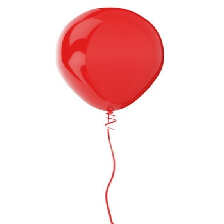

In [15]:
url = "https://cdn.education.com/files/526001_527000/526114/file_526114.jpg"
os.system("curl " + url + " > balloon.jpg")
img_path = 'balloon.jpg'
img = image.load_img(img_path, target_size=(224, 224))
display(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) # 각 모델을 학습할 때 preprocess했던 방법을 사용

evaluate 할 때는 다음 함수를 이용

In [16]:
def evaluate_model_practice(interpreter, test_images):
    
    input_details = interpreter.get_input_details()[0]
    input_index = input_details["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for test_image in tqdm(test_images):
        # quantize input
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        # Pre-processing: add batch dimension
        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        preds = interpreter.tensor(output_index)
        preds = np.expand_dims(preds()[0], axis=0)

    return preds

In [17]:
# 1. import한 pretrain 모델 가져오기
imagenet = ResNet50(weights='imagenet')

preds = imagenet.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

1/1 [==============================] - 3s 3s/step
Predicted: [('n02782093', 'balloon', 0.9515529), ('n04023962', 'punching_bag', 0.03351856), ('n03544143', 'hourglass', 0.001822629)]


크기 비교를 위한 32bit float tflite 모델

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(imagenet)
imagenet_tflite = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\steve\AppData\Local\Temp\tmpdqyd_ev5\assets


INFO:tensorflow:Assets written to: C:\Users\steve\AppData\Local\Temp\tmpdqyd_ev5\assets


In [19]:
# 2. full integer post-training quantization
import numpy as np
def representative_data_gen():
    yield [x] # test할 이미지 1개만 사용

converter = tf.lite.TFLiteConverter.from_keras_model(imagenet)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

post_quant_imagenet_tflite = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\steve\AppData\Local\Temp\tmp4pnd9lek\assets


INFO:tensorflow:Assets written to: C:\Users\steve\AppData\Local\Temp\tmp4pnd9lek\assets
C:\Users\steve\.conda\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [20]:
# 3. make interpreter and do inference
# tflite 모델로 interpreter 만듦
post_quant_imagenet_interpreter = tf.lite.Interpreter(model_content=post_quant_imagenet_tflite)

post_quant_imagenet_interpreter.allocate_tensors()

preds = evaluate_model_practice(post_quant_imagenet_interpreter, x)
print('Predicted:', decode_predictions(preds, top=3)[0])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:27<00:00, 27.00s/it]

Predicted: [('n02782093', 'balloon', 239), ('n04023962', 'punching_bag', 13), ('n03544143', 'hourglass', 1)]


In [21]:
# Measure sizes of models.
_, imagenet_tflite_file = tempfile.mkstemp('.tflite')
_, post_quant_imagenet_tflite_file = tempfile.mkstemp('.tflite')


with open(tflite_file, 'wb') as f:
    f.write(imagenet_tflite)

with open(post_quant_tflite_file, 'wb') as f:
    f.write(post_quant_imagenet_tflite)


tflite_qat_size = os.path.getsize(tflite_file) / float(2**20)
quantized_size = os.path.getsize(post_quant_tflite_file) / float(2**20)
    
print(f"Float model: {tflite_qat_size:.03f} MB")
print(f"Quantized model: {quantized_size:.03f} MB")
print(f"Quantized model: {quantized_size/tflite_qat_size:.02f} x Float model size", )

Float model: 97.430 MB
Quantized model: 25.079 MB
Quantized model: 0.26 x Float model size


### 1-2. [Quantization Aware Training(QAT)](https://blog.tensorflow.org/2020/04/quantization-aware-training-with-tensorflow-model-optimization-toolkit.html)

수업 시간에 배웠 듯이 QAT는 나중에 quantization을 할 것이라는 것을 가정하고 학습하는 것이다. scratch부터 학습해도 되지만, 이미 학습된 모델을 fine tuning 하는 것이 좋다고 한다.

In [22]:
!pip install -q tensorflow-model-optimization

In [23]:
import tensorflow_model_optimization as tfmot

### Quantize whole model

Edge TPU와 같이 fully quantized 모델이 필요한 경우에는 전체 모델에 대해 QAT를 한다.

위에서 학습한 float32모델로 QAT를 해볼 것이다.`quantize_model`함수를 이용한다.

In [24]:
quant_aware_model = tfmot.quantization.keras.quantize_model(model)

# `quantize_model` requires a recompile.
quant_aware_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

quant_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28)           3         
 er)                                                             
                                                                 
 quant_reshape (QuantizeWrap  (None, 28, 28, 1)        1         
 perV2)                                                          
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 28, 28, 16)       195       
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 14, 14, 16)       1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 14, 14, 32)       4

layer에 quant가 붙은 것을 확인할 수 있다. 그 다음으로는, data의 일부를 이용해서 fine tuning 한다.

In [25]:
# data 일부를 이용해서 fine tuning
train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

quant_aware_model.fit(train_images, train_labels, batch_size=500, epochs=10, validation_split=0.1)
model.fit(train_images, train_labels, batch_size=500, epochs=10, validation_split=0.1)

Epoch 1/10
108/108 [==============================] - 7s 56ms/step - loss: 0.1597 - accuracy: 0.9440 - val_loss: 0.2357 - val_accuracy: 0.9170
Epoch 2/10
108/108 [==============================] - 6s 54ms/step - loss: 0.1537 - accuracy: 0.9453 - val_loss: 0.2372 - val_accuracy: 0.9158
Epoch 3/10
108/108 [==============================] - 6s 54ms/step - loss: 0.1494 - accuracy: 0.9470 - val_loss: 0.2382 - val_accuracy: 0.9152
Epoch 4/10
108/108 [==============================] - 6s 54ms/step - loss: 0.1493 - accuracy: 0.9466 - val_loss: 0.2405 - val_accuracy: 0.9148
Epoch 5/10
108/108 [==============================] - 6s 54ms/step - loss: 0.1457 - accuracy: 0.9489 - val_loss: 0.2396 - val_accuracy: 0.9153
Epoch 6/10
108/108 [==============================] - 6s 54ms/step - loss: 0.1428 - accuracy: 0.9497 - val_loss: 0.2455 - val_accuracy: 0.9162
Epoch 7/10
108/108 [==============================] - 6s 54ms/step - loss: 0.1403 - accuracy: 0.9503 - val_loss: 0.2377 - val_accuracy: 0.9165

아직 quantization을 하지 않았으므로 weight은 실수이다.

In [26]:
quant_aware_model.layers[2].get_weights()

[array([[[[-2.97805928e-02, -7.43684113e-01, -2.74659488e-02,
           -3.36150527e-01, -1.51646242e-01,  2.80483454e-01,
           -3.75585333e-02,  4.74252820e-01, -1.58959344e-01,
            3.64487827e-01,  7.50890374e-02,  1.80487379e-01,
           -4.17069763e-01,  5.73657341e-02, -4.25913185e-01,
            6.07960746e-02]],
 
         [[ 4.22853321e-01,  4.99973953e-01, -5.77079117e-01,
            1.63602322e-01, -3.52849871e-01,  5.39748073e-01,
            3.13947350e-01,  5.41177243e-02, -3.15265089e-01,
            4.79595333e-01, -1.02142207e-01, -4.15292531e-01,
           -2.87013054e-02,  2.50699997e-01, -6.11357868e-01,
           -8.99027511e-02]],
 
         [[-7.17292652e-02,  1.78618535e-01, -2.41443440e-01,
            2.24919006e-01,  5.02402596e-02, -6.94538057e-01,
           -2.02082738e-01, -5.22242486e-01,  4.98584688e-01,
            3.93959075e-01,  8.95497389e-03,  3.00242126e-01,
            1.50624916e-01,  2.65799791e-01, -1.46604791e-01,
      

실수 weight이므로 QAT를 한다고 해서 accuracy가 떨어지지 않는다.

In [27]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

_, quant_aware_model_accuracy = quant_aware_model.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('QAT test accuracy:', quant_aware_model_accuracy)

Baseline test accuracy: 0.9157000184059143
QAT test accuracy: 0.9136000275611877


이제 QAT로 학습한 모델을 quantization 해보자. post-training quantization과 비슷하게 TFLiteConverter를 이용하면 된다.

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8 # or tf.int8
converter.inference_output_type = tf.uint8 # or tf.int8


QAT_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\steve\AppData\Local\Temp\tmp2crpxhln\assets


INFO:tensorflow:Assets written to: C:\Users\steve\AppData\Local\Temp\tmp2crpxhln\assets
C:\Users\steve\.conda\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


quantization을 해도 accuracy가 떨어지지 않는 것을 알 수 있다.

In [29]:
QAT_interpreter = tf.lite.Interpreter(model_content=QAT_tflite_model)
QAT_interpreter.allocate_tensors()

QAT_test_accuracy, output = evaluate_model(QAT_interpreter)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Post-training Quantized test accuracy:', post_quant_tflite_test_accuracy)
print('Quantization-Aware Training test accuracy:', QAT_test_accuracy)


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:15<00:00, 132.59it/s]


Baseline test accuracy: 0.9157000184059143
Post-training Quantized test accuracy: 0.9072
Quantization-Aware Training test accuracy: 0.9133


마찬가지로 크기가 1/4로 줄어든 것을 알 수 있다.

In [30]:
# create temp file
_, QAT_tflite_file = tempfile.mkstemp('.tflite')

with open(QAT_tflite_file, 'wb') as f:
    f.write(QAT_tflite_model)
    
    
quantized_size = os.path.getsize(QAT_tflite_file) / float(2**20)

print(f"Float tflite model: {tflite_size:.03f} MB")
print(f"Quantized QAT model: {quantized_size:.03f} MB")
print(f"Quantized QAT model: {quantized_size/tflite_size:.02f} x Float model size", )

Float tflite model: 0.082 MB
Quantized QAT model: 0.026 MB
Quantized QAT model: 0.32 x Float model size


### Quantize some layers

Edge TPU 등 특별한 하드웨어가 아닌 경우에는 선택적으로 layer를 quantization할 수도 있다.

**Tips for better accuracy**
* from scratch보다는 fine tuning
* 뒤쪽 layer를 quantization 하기
* 특별히 중요한 layer는 quantization 피하기


`quantize_annotate_layer` 함수를 이용해서 특정 layer를 quantization할 것이라고 표시한다.

In [31]:
model.layers[-1].name

'dense'

In [32]:
# Helper Function
def apply_quantization_to_dense(layer):
    # if isinstance(layer, tf.keras.layers.Dense)
    if layer.name == 'dense':
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    else:
        return layer

`clone_model` 함수와 helper function을 이용해서 annotated model을 만들고, `quantize_apply`함수를 이용해서 QAT를 위한 모델을 만들면 된다.

In [33]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization_to_dense,
)
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 quant_flatten (QuantizeWrap  (None, 1568)             1

만약 fine tuning이 아니라 처음부터 모델을 만드는 것이면 다음과 같이 모델을 만들면 된다.

**Sequential example**

In [34]:
annotated_model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Dense(10))
])
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

quant_aware_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 12)       0         
 2D)                                                             
                                                                 
 quant_flatten_1 (QuantizeWr  (None, 2028)             1         
 apperV2)                                                        
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 10)               20295     
 perV2)                                                          
                                                      

**Functional example**

In [35]:
inputs = tf.keras.Input(shape=(28, 28))
x = tf.keras.layers.Reshape(target_shape=(28, 28, 1))(inputs)
x = tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'))(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10)(x)

annotated_model = tf.keras.Model(inputs=inputs, outputs=outputs)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

quant_aware_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 quant_reshape_2 (QuantizeWr  (None, 28, 28, 1)        1         
 apperV2)                                                        
                                                                 
 quant_conv2d_3 (QuantizeWra  (None, 26, 26, 12)       147       
 pperV2)                                                         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 12)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2028)              0         
                                                             

## 2. [Pruning](https://blog.tensorflow.org/2019/05/tf-model-optimization-toolkit-pruning-API.html)

pruning은 불필요한(0에 가까운) weight을 0으로 만들어 없애면서 optimize를 한다.

`tfmot.sparsity.keras.prune_low_magnitude`을 이용해서 모델을 만든다. 이 때, pruning 방식인 `tfmot.sparsity.keras.PolynomialDecay` 을 parameter로 넘겨준다. 다음과 같은 hyperparemeter가 있다.
* `initial_sparsity`: pruning을 시작할 때의 sparsity를 몇으로 할 지
* `final_sparsity`: pruning을 끝낼 때의 sparsity를 몇으로 할 지
* `begin_step`: pruning을 언제부터 진행할 지 (batch 단위의 step)
* `end_step`: pruning을 언제 끝낼 지

pruning을 하기 전에 baseline model을 저장하겠다. (크기 비교시 사용)

In [36]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Baseline test accuracy: 0.9157000184059143
Saved baseline model to: C:\Users\steve\AppData\Local\Temp\tmpkdn_znh2.h5


In [37]:
# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_reshape  (None, 28, 28, 1)        1         
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_conv2d   (None, 28, 28, 16)       306       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_max_poo  (None, 14, 14, 16)       1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 14, 14, 32)       9250      
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 7, 7, 32)         1

`fit`을 할 때, `tfmot.sparsity.keras.UpdatePruningStep`을 callback으로 불러야 한다

In [38]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/2


C:\Users\steve\.conda\envs\tf\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


  6/422 [..............................] - ETA: 4s - loss: 0.1437 - accuracy: 0.9557   WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0096s vs `on_train_batch_end` time: 0.0198s). Check your callbacks.


422/422 [==============================] - 13s 14ms/step - loss: 0.2628 - accuracy: 0.9038 - val_loss: 0.3353 - val_accuracy: 0.8822
Epoch 2/2
422/422 [==============================] - 5s 12ms/step - loss: 0.2813 - accuracy: 0.8979 - val_loss: 0.2912 - val_accuracy: 0.8970


baseline 모델과 accuracy를 비교해 보자.

In [39]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.9157000184059143
Pruned test accuracy: 0.8914999961853027


pruned model의 크기가 줄어들었는 지 확인해 보자.

위에 summary를 보면 pruning을 하기 위해 non-trainable parameter가 생긴 것을 알 수 있다. `tfmot.sparsity.keras.strip_pruning`을 이용해서 pruning에 사용한 variable을 제거해 준다.

In [40]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: C:\Users\steve\AppData\Local\Temp\tmp7ewcmwb9.h5


tflite 으로 저장

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: C:\Users\steve\AppData\Local\Temp\tmpkz7wp4_2\assets


INFO:tensorflow:Assets written to: C:\Users\steve\AppData\Local\Temp\tmpkz7wp4_2\assets


Saved pruned TFLite model to: C:\Users\steve\AppData\Local\Temp\tmp_4pclva_.tflite


pruning을 해도 weight matrix의 크기는 그대로이다. 하지만 matrix의 값이 대부분 0이기 때문에 감소된 크기를 확인하려면 실제로 zip파일 등으로 압축하는 과정을 거쳐야 한다.

In [42]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    return os.path.getsize(zipped_file)

In [43]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped baseline Keras model: 78969.00 bytes
Size of gzipped pruned Keras model: 26686.00 bytes
Size of gzipped pruned TFlite model: 25419.00 bytes


### Combine pruning and quantization
pruning을 한 다음에 post-training quantization까지 하면 크기를 더 줄일 수 있다.

In [44]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
    f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))
print(f"Size of optimized model is {get_gzipped_model_size(quantized_and_pruned_tflite_file)/get_gzipped_model_size(keras_file):.02f} of the baseline model")

INFO:tensorflow:Assets written to: C:\Users\steve\AppData\Local\Temp\tmph1dadejl\assets


INFO:tensorflow:Assets written to: C:\Users\steve\AppData\Local\Temp\tmph1dadejl\assets
C:\Users\steve\.conda\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Saved quantized and pruned TFLite model to: C:\Users\steve\AppData\Local\Temp\tmpdwkcziqh.tflite
Size of gzipped baseline Keras model: 78969.00 bytes
Size of gzipped pruned and quantized TFlite model: 9704.00 bytes
Size of optimized model is 0.12 of the baseline model


baseline 과 accuracy를 비교해 보자

In [45]:
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()

test_accuracy, _ = evaluate_model(interpreter)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned and quantized TFLite test_accuracy:', test_accuracy)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:15<00:00, 132.07it/s]


Baseline test accuracy: 0.9157000184059143
Pruned and quantized TFLite test_accuracy: 0.8917


QAT와 비슷하게, pruning도 layer를 선택적으로 pruning 할 수 있다. 이 부분은 [document](https://www.tensorflow.org/model_optimization/guide/pruning/comprehensive_guide)를 참고